In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# load all model and data
model = load_model('../models/lstm_model.h5')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

In [ ]:
predicted_scaled = model.predict(X_test) # output the prediction
print("Predicted shape: ", predicted_scaled.shape)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Predicted shape:  (287, 1)


In [ ]:
df = pd.read_csv('../data/aapl.csv', index_col=0, parse_dates=True)

numeric_columns = ["Open", "High", "Close", "Low", "Volume"]
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # convert to numeric value else leave null

# Recompute features
import ta
df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df = df.dropna()

features = ['Close', 'SMA_20', 'RSI', 'MACD', 'Close_lag1', 'Close_lag2', 'Close_lag3']
scaler = MinMaxScaler() # scale model for LLM
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

C:\Users\bhatt\AppData\Local\Temp\ipykernel_18692\1604894544.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/aapl.csv', index_col=0, parse_dates=True)


In [ ]:
actual_scaled_close = y_test.reshape(-1, 1) # makes column vector

pad = np.zeros((len(predicted_scaled), 6)) # create zeros to fill missing 6 features
# reconstruct full arrays 
predicted_full = np.concatenate((predicted_scaled, pad), axis=1)
actual_full = np.concatenate((actual_scaled_close, pad), axis=1)

# Invert scaling to see real dollar prices instead of the normalized values (0-1 range)
predicted_prices = scaler.inverse_transform(predicted_full)[:, 0] # take only the first column
actual_prices = scaler.inverse_transform(actual_full)[:, 0]

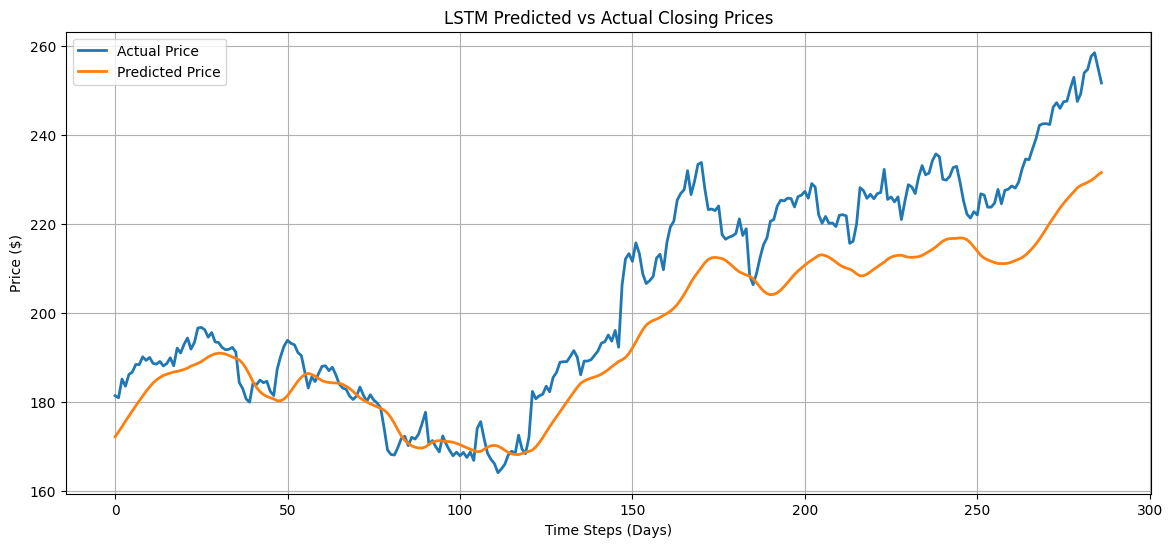

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual Price', linewidth=2)
plt.plot(predicted_prices, label='Predicted Price', linewidth=2)
plt.title('LSTM Predicted vs Actual Closing Prices')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

In [16]:
result_df = pd.DataFrame({
    'Actual': actual_prices,
    'Predicted': predicted_prices
})
result_df.to_csv('../data/predicted_vs_actual.csv', index=False)
